# Unit Testing for Data Science (Berlin WiMLDS Workshop)
## Exploratory Data Analysis

This notebook contains exploratory data analysis of a dataset based on the [Pockets dataset from The Pudding](https://github.com/the-pudding/pockets). In order to try out different imputation methods we removed 10% of the price values.

You can use this notebook to get an overview of the dataset or write functions for the exercises, before transfering them to the appropriate Python scripts.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# read pockets dataset with 10% missing price values
df = pd.read_csv(
    "data/measurementRectanglesMissing.csv"
)  # to not index on user id..as we got duplicates that we need
print(df.columns)

Index(['brand', 'style', 'menWomen', 'name', 'fabric', 'price',
       'maxHeightFront', 'minHeightFront', 'rivetHeightFront', 'maxWidthFront',
       'minWidthFront', 'maxHeightBack', 'minHeightBack', 'maxWidthBack',
       'minWidthBack', 'cutout', 'waistSize', 'updatedStyle', 'group',
       'priceGroup', 'pocketArea', 'rectanglePhone', 'rectanglePen',
       'rectangleWallet', 'rectangleHand', 'rectangeWallet'],
      dtype='object')


## Imputing missing values

In [3]:
# how many missing values in 'price' column?
print("Number of missing values: ", df.price.isnull().sum())
df_impute = df.copy()

Number of missing values:  8


In [4]:
# fucntion to impute NaNs with mean value
def impute(series: pd.Series) -> pd.Series:
    mean = series.mean()
    return series.fillna(mean)

In [5]:
df_impute["price"] = impute(df_impute["price"])

In [6]:
df_impute.price.isnull().sum() 

0

### TODO: Exercise 1

Add functions to impute missing values with min/max values, then add unit tests.

Don't forget to add your functions to `imputation.py` and your unit tests to `test_imputation.py`

In [7]:
# write your functions/unit tests here
# don't forget to transfer to appropriate scripts after

## Explore the dataset

In [7]:
#transforming categorical columns to categorical type: brand style menWomen
df["brand"] = df["brand"].astype("category")
df["style"] = df["style"].astype("category")
df["menWomen"] = df["menWomen"].astype("category")

### Are womens jeans more expensive?

In [8]:
df.price.describe()

count    72.000
mean     80.989
std      45.247
min       9.990
25%      49.980
50%      73.975
75%      95.713
max     249.000
Name: price, dtype: float64

In [9]:
# bin prices by min/max value, upper/lower percentiles
bins = [9, 50, 74, 96, 250]
df['price_binned'] = pd.cut(df['price'], bins)

In [10]:
# women jeans are not really more expensive
pd.crosstab(df["menWomen"], df.price_binned)

price_binned,"(9, 50]","(50, 74]","(74, 96]","(96, 250]"
menWomen,,,,
men,11,8,7,9
women,11,6,11,9


### Are women pockets smaller?

In [11]:
df.pocketArea.describe()

count      80.000
mean     8424.815
std      2699.333
min      4454.429
25%      5905.184
50%      8618.737
75%     10724.592
max     13102.032
Name: pocketArea, dtype: float64

In [12]:
# bin pocketArea by min/max value, upper/lower percentiles
bins = [4454, 5906, 8619, 10725, 13103]
df['pocket_binned'] = pd.cut(df['pocketArea'], bins)

In [13]:
# women's pocket sizs are smaller
pd.crosstab(df["menWomen"], df.pocket_binned, normalize="columns")

pocket_binned,"(4454, 5906]","(5906, 8619]","(8619, 10725]","(10725, 13103]"
menWomen,,,,
men,0.000,0.100,0.900,1.000
women,1.000,0.900,0.100,0.000


## Data Transformations - Get women pocket size score for each brand

To get this score we can do a simple approach and a more complex one

#### Add column is_size_greater_than_average
Add column is_size_greater_than_average (per brand / per dataset) -> with values from 0 to 2, the number of women jeans that are larger than average in that brand

In [18]:
# Creating a column with data transformation of another column
# This function is also in scripts/transformation.py
def is_greater_than_average(series: pd.Series) -> pd.Series :
    avg = series.mean()
    new_series = [0 if x <= avg else 1 for x in series]

    return pd.Series(new_series)

In [19]:
df["size_greater_than_average"] = is_greater_than_average(df["pocketArea"])
print("How many pockets are of size greater than average?: ", df["size_greater_than_average"].sum())

How many pockets are of size greater than average?:  41


In [20]:
# the test failed, and if we uncomment the next line we see this fails too
is_greater_than_average(df["pocketArea"]).sum()

41

### TODO: Exercise 2

We have accidentaly stumbled upon a situation where even though something works in the "notebook", when used as a function, and maybe later in a pipeline it could fail. So our test kinda failed for the wrong reasons.

- Change the test to a data type test.
- Add more tests to the function `is_greater_than_average`. How does it work when all values in the series are the same?

Don't forget to add your unit tests to `test_transformation.py`.

In [ ]:
# write test

#### Add column get_pocket_size_score
Add column get_pocket_size_score -> return a score based on if women pocket sizes are higher than average (by brand in relation to the rest maybe)


### TODO: Exercise 3
- add function to new script (e.g., `scoring.py`)
- add a unit test file in test folder for the new function (e.g., `test_scoring.py`)
- write tests. Can the following function be tested as it is written? Does it follow testable functions conventions?

In [21]:
# count number of rows with women and "size_greater_than_average" > 0
# input brand, menWomen, size_greater_than_average -> 80 rows
# output brand, score  -> less ~ 40

aggr = df.groupby(by=["brand", "menWomen"],as_index=False)["size_greater_than_average"].sum()

In [22]:
def get_sum_score_by_brand_and_gender(frame: pd.DataFrame, brand_col="brand", gender_col="menWomen", score_by="size_greater_than_average") -> pd.DataFrame :
    aggr = frame.groupby(by=[brand_col, gender_col],as_index=False)[score_by].sum()

    return aggr

In [23]:
aggr = get_sum_score_by_brand_and_gender(df, "brand", "menWomen", "size_greater_than_average")
aggr

,brand,menWomen,size_greater_than_average
0,7 for All Mankind,men,2
1,7 for All Mankind,women,0
2,Abercrombie,men,2
3,Abercrombie,women,2
4,American Eagle,men,2
5,American Eagle,women,0
6,Arizona,men,2
7,Arizona,women,0
8,Buckle Black,men,2
9,Buckle Black,women,0


In [24]:
aggr[aggr.menWomen == "women"]

,brand,menWomen,size_greater_than_average
1,7 for All Mankind,women,0
3,Abercrombie,women,2
5,American Eagle,women,0
7,Arizona,women,0
9,Buckle Black,women,0
11,Calvin Klein,women,0
13,Express,women,0
15,Gap,women,0
17,Guess,women,0
19,H&M,women,0


In [ ]:
#todo: write the test

## Homework


### a less all or nothing score

we sort the pocket areas and assign to each row the index of the area value ( values should be 0 - dataframe size)
- brand women score = average position (sum / 2)
- brand men score = average position (sum / 2)
- score = women / men

todo: 
- write this as a testable function, add this to the `scoring.py` (you might need more than one function)
- write unit tests for these functions

In [22]:
df_small = df[["brand", "menWomen", "pocketArea"]]

In [23]:
df_small = df_small.sort_values("pocketArea").reset_index(drop=True)

In [24]:
df_small['rank'] = df_small.index + 1

In [25]:
df_small

,brand,menWomen,pocketArea,rank
0,Gap,women,4454.429,1
1,Guess,women,4490.844,2
2,Guess,women,4572.572,3
3,Gap,women,4612.939,4
4,Calvin Klein,women,4702.028,5
...,...,...,...,...
75,Arizona,men,12667.656,76
76,Arizona,men,12751.060,77
77,Ralph Lauren,men,12792.598,78
78,Wrangler,men,13079.606,79


In [26]:
aggr = df_small.groupby(by=["brand", "menWomen"],as_index=False)["rank"].sum()

In [27]:
aggr

,brand,menWomen,rank
0,7 for All Mankind,men,131
1,7 for All Mankind,women,37
2,Abercrombie,men,111
3,Abercrombie,women,90
4,American Eagle,men,98
5,American Eagle,women,64
6,Arizona,men,153
7,Arizona,women,62
8,Buckle Black,men,115
9,Buckle Black,women,57


# About this data

source: https://github.com/the-pudding/data/tree/master/pockets

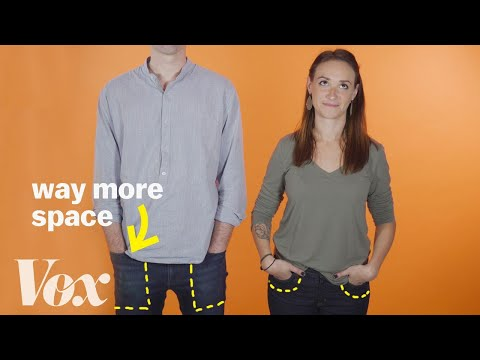

In [25]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('Vi2Vgym6lbw')